# Importing Libraries
We begin by importing the necessary libraries: numpy, pandas, datetime, yfinance, matplotlib, and scipy.stats.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# Setting Time Range and Ticker List
In this section, we set the time range for our historical data to 15 years and create a list of stock tickers for our portfolio.

In [2]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

# Downloading Adjusted Close Prices
Next, we download the daily adjusted close prices for each stock ticker using the yfinance library and store the data in a DataFrame.

In [3]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-10-06   78.371605  48.870636   84.279999   30.494030   39.873894
2008-10-07   74.861641  49.013233   87.269997   28.560816   37.439713
2008-10-08   72.975723  48.287125   89.419998   28.333374   36.723782
2008-10-09   67.879143  46.783024   89.900002   27.572346   34.417694
2008-10-10   66.232712  45.356716   83.220001   27.397400   33.422920
...                ...        ...         ...         ...         ...
2023-09-25  432.230011  69.949997  177.699997  359.609985  214.500000
2023-09-26  425.880005  6

# Calculating Daily Log Returns
We calculate the daily log returns for each stock in our portfolio and drop any missing values.

In [4]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-10-07 -0.045820  0.002914  0.034862 -0.065495 -0.062990
2008-10-08 -0.025515 -0.014925  0.024338 -0.007995 -0.019307
2008-10-09 -0.072398 -0.031645  0.005354 -0.027227 -0.064854
2008-10-10 -0.024554 -0.030962 -0.077210 -0.006365 -0.029329
2008-10-13  0.135577  0.040754 -0.014890  0.114799  0.120710
...              ...       ...       ...       ...       ...
2023-09-25  0.004196 -0.007406 -0.005164  0.004739  0.004017
2023-09-26 -0.014800 -0.001001 -0.008023 -0.015130 -0.014510
2023-09-27  0.000399 -0.003584 -0.012444  0.002341  0.001040
2023-09-28  0.005781  0.002582 -0.005010  0.008330  0.006594
2023-09-29 -0.002430 -0.000430 -0.010329  0.000726 -0.002915

[3771 rows x 5 columns]


# Defining Functions to Calculate Portfolio Expected Return and Standard Deviation
We define two functions, expected_return() and standard_deviation(), which will be used to calculate the expected return and standard deviation of our portfolio, respectively.

In [6]:
### Create a function that will be used to calculate portfolio expected return
# We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Creating a Covariance Matrix
We create a covariance matrix for all the securities in our portfolio using the daily log returns.

In [7]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.614248e-04  6.340882e-07  0.000010  1.660758e-04  1.625414e-04
BND  6.340882e-07  1.045190e-05  0.000009  3.395646e-07  5.534251e-07
GLD  1.002762e-05  8.610329e-06  0.000111  9.373448e-06  1.066887e-05
QQQ  1.660758e-04  3.395646e-07  0.000009  1.990061e-04  1.683314e-04
VTI  1.625414e-04  5.534251e-07  0.000011  1.683314e-04  1.654476e-04


# Calculating Portfolio Expected Return and Standard Deviation
We create an equally weighted portfolio and calculate the portfolio’s expected return and standard deviation using the functions we defined earlier.

In [8]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

# Defining Functions for Monte Carlo Simulation

We define two functions: random_z_score() and scenario_gain_loss(). The first function generates a random Z-score based on a normal distribution, and the second function calculates the gain or loss for a given scenario.

In [9]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

# Running Monte Carlo Simulation
We run 10,000 Monte Carlo simulations, calculating the scenario gain/loss for each simulation and storing the results in a list.

In [10]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

# Calculating Value at Risk (VaR)
We specify a confidence interval of 99% and calculate Value at Risk (VaR) using the results of our simulations.

In [11]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

79788.776614488


# Plotting the Results
Finally, we create a histogram to visualize the distribution of portfolio gain/loss over the specified number of days. We also add a vertical dashed line to indicate the VaR at our chosen confidence level.

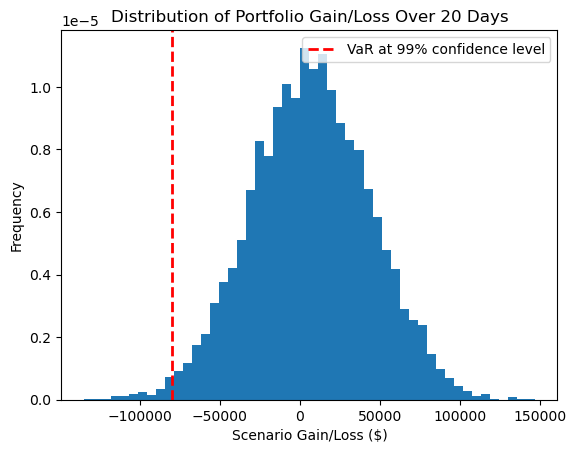

In [12]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

# Conclusion
This blog post has demonstrated how to calculate Value at Risk (VaR) for a portfolio of stocks using Python and its powerful libraries such as numpy, pandas, yfinance, matplotlib, and scipy. By running Monte Carlo simulations, we have estimated the potential loss in our portfolio over a specified number of days and at a given confidence level. This information can be invaluable for investors and portfolio managers when assessing the risk associated with their investment decisions. 